In [107]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from collections import Counter, defaultdict

In [2]:
with open('../data/preds.csv', 'r') as f:
    lines = f.readlines()
    
if os.path.exists("../data/dataset.pkl"):
    with open("../data/dataset.pkl", "rb") as f:
        data = pickle.load(f)
    
raw_data = pd.read_csv("../data/final_ckpt_with_labels.csv")

Transform predictions DataFrame

In [14]:
lines = [x.strip().split(',') for x in lines]

epoch = -1
epoch_wise_results = defaultdict(str)

for i in range(len(lines)):
    if lines[i][0] == '2000':
        epoch += 1
    
    epoch_wise_results[epoch] += ',' + ','.join(lines[i][1:])
    
final_epoch_results = np.array([float(x) for x in epoch_wise_results[99].split(',')[1:]])

In [ ]:
X_test = data["X_test"]
y_test = data["y_test"]
fake_pos = data["fake_pos"]
gene = data["gene"]
test_meta = data["test_meta"]

In [16]:
pos_predictions = set(np.where(final_epoch_results == 1.)[0])
fake_positives = set(np.where(y_test == 1.)[0])

len(fake_positives.intersection(pos_predictions))

In [29]:
# List of masked positives not detected by the model
fake_positives - pos_predictions

{9570,
 14694,
 17262,
 25799,
 30215,
 33861,
 35904,
 36220,
 46274,
 52394,
 59500,
 59562,
 69617,
 70408,
 72268,
 77881,
 91801,
 94754,
 100152,
 106190,
 108959,
 111552}

**Analysis of Masked Positives Not Detected**

In [46]:
indices = [str(x) if x < 0 else '+' + str(x) for x in np.arange(-15, 16)]

cols_for_idx = {}

for idx in indices:
    cols_for_idx['total_rl' + idx] = [x for x in raw_data.columns if x.startswith('rl') and x.endswith(idx)]

In [54]:
# Total reads at each position near the start site (-15, -14, ..., +14, +15)
for k, v in cols_for_idx.items():
    raw_data[k] = raw_data[v].sum(axis=1)
    
# Total reads in the neighborhood
raw_data['total_reads'] = raw_data[cols_for_idx.keys()].sum(axis=1)

In [95]:
# Masked positives not detected
fake_pos_not_detected = test_meta.iloc[list(fake_positives - pos_predictions)][['position', 'gene']]
df_fpn = raw_data[raw_data['position'].isin(fake_pos_not_detected['position'].values)]

# Masked positives detected
fake_pos_detected = test_meta.iloc[list(pos_predictions.intersection(fake_positives))][['position', 'gene']]
df_fpd = raw_data[raw_data['position'].isin(fake_pos_detected['position'].values)]

# All positive predictions of the model
pos_preds = test_meta.iloc[list(pos_predictions)][['position', 'gene']]
df_pp = raw_data[raw_data['position'].isin(pos_preds['position'].values)]

In [137]:
df_fpd.shape[0], df_fpn.shape[0]

(78, 22)

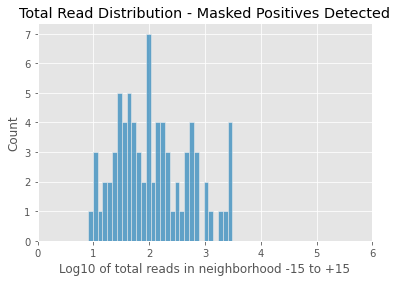

In [147]:
sns.histplot(np.log10(df_fpd['total_reads']), bins=30)
plt.title('Total Read Distribution - Masked Positives Detected')
plt.xlabel('Log10 of total reads in neighborhood -15 to +15')
plt.xlim(0, 6)
plt.show()

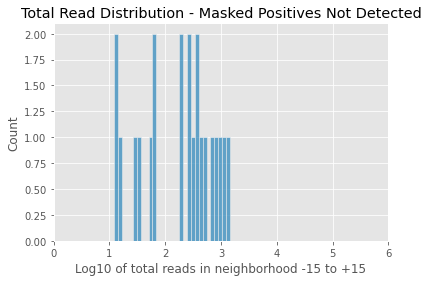

In [148]:
sns.histplot(np.log10(df_fpn['total_reads']), bins=30)
plt.title('Total Read Distribution - Masked Positives Not Detected')
plt.xlabel('Log10 of total reads in neighborhood -15 to +15')
plt.xlim(0, 6)
plt.show()

**T-Test**

$H_0: \mu_x = \mu_y$ \
$H_1: \mu_x \ne \mu_y$

In [138]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("Welch's t-test =>\n",
          f"Score = {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom = {dof:.4f}")

In [139]:
welch_ttest(df_fpd['total_reads'], df_fpn['total_reads'])

Welch's t-test =>
 Score = 0.0865 
 p-value = 0.9313 
 Welch-Satterthwaite Degrees of Freedom = 59.3030


In [140]:
welch_ttest(df_fpd['total_rl+0'], df_fpn['total_rl+0'])

Welch's t-test =>
 Score = -1.6654 
 p-value = 0.1092 
 Welch-Satterthwaite Degrees of Freedom = 23.2661


**Save results to CSV**

In [24]:
print("Saving potential start sites to a CSV file.\n")
positive_predicted = test_meta.iloc[list(pos_predictions)][['position', 'gene']]
print("Total number of masked start sites detected =", positive_predicted['gene'].notnull().sum()) # Should be < 100
print("Total number of masked start sites =", test_meta['gene'].notnull().sum()) # Should be 100

print("Saving to csv...", end='')
positive_predicted.to_csv("../data/positive_predicted_9lp_1.csv")
print("Done.")

In [119]:
positive_predicted

,position,gene
33112,1131013,NaN
33116,1131017,NaN
41387,1335831,b1276
91160,3950305,NaN
16557,461362,NaN
...,...,...
74536,3104430,NaN
99395,4173097,NaN
57960,2105323,NaN
16530,458889,NaN
